# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt', encoding='utf8') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        return self.embeddings[self.word2id[word]]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        w1, w2 = self.encode(word1), self.encode(word2)
        return w1 @ w2 / (np.linalg.norm(w1) * np.linalg.norm(w2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        similarities = list(map(lambda x: (x, self.score(word, x)), self.words))
        top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[1:k+1]
        
        return top_k

In [4]:
from pprint import pprint

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
print('\nA few word similarities:')
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), 
                        ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))

print('\nk most similar words:')
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word)
    pprint(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors

A few word similarities:
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003

k most similar words:
cat
[('cats', 0.8350197226384365),
 ('kitty', 0.8233399968187781),
 ('kitten', 0.8082815099576771),
 ('feline', 0.7533785551165829),
 ('dog', 0.7078641298542564)]
dog
[('dogs', 0.8463550976711899),
 ('puppy', 0.7873139069340451),
 ('pup', 0.7692395715695702),
 ('canine', 0.7435156195681728),
 ('pet', 0.7333897457373171)]
dogs
[('dog', 0.8463550976711899),
 ('cats', 0.7548146151613192),
 ('puppies', 0.7393920521595102),
 ('Dogs', 0.7033621979701274),
 ('pets', 0.6778314127464548)]
Paris
[('France', 0.6892958925806543),
 ('Parisian', 0.6863845504588244),
 ('Marseille', 0.6731069551350876),
 ('Brussels', 0.6674311464893566),
 ('Strasbourg', 0.6576519658835766)]
Germany
[('Austria', 0.7433367

In [5]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.idf = dict()
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        for sentence in sentences:
            words = set(sentence.split(' '))  # to count words only once in the sentence
            for word in words:
                if word in self.idf.keys():
                    self.idf[word] += 1
                else:
                    self.idf[word] = 1  # create the key if it does not already exist
        
        n_sentences = len(sentences)
        for word in self.idf.keys():
            self.idf[word] = np.log(n_sentences / self.idf[word])
        
        return self.idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        words = self.word2vec.words
        sentence_w = [w for w in sentence.split(' ') if w in words]
        if idf is None:
            # mean of word vectors
            sentence_embedding = np.vstack([
                self.word2vec.embeddings[self.word2vec.word2id[word]] for word in sentence_w
            ])
            sentence_embedding = np.mean(sentence_embedding, axis=0)
        else:
            # idf-weighted mean of word vectors
            sentence_embedding = np.vstack([
                idf[word] * self.word2vec.embeddings[self.word2vec.word2id[word]] for word in sentence_w
            ])
            sentence_embedding = np.sum(sentence_embedding, axis=0)
        
        return sentence_embedding

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        s1, s2 = self.encode(sentence1, idf), self.encode(sentence2, idf)
        return s1 @ s2 / (np.linalg.norm(s1) * np.linalg.norm(s2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        keys = [(x, self.score(x, sentence, idf)) for x in sentences]
        top_k = sorted(keys, key=lambda x: x[1], reverse=True)
        top_k = list(map(lambda x: x[0], top_k))[1:k+1]
        
        return top_k

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400799939346387
a young boy and 2 girls open christmas presents . 
1) 3 girls and one boy playing in the street . 
2) a group of friends , 3 boys and 2 girls , jump in the air holding hands for a photo . 
3) five children , 3 boys and 2 girls playing soccer in a grass field . 
4) 2 young indian girls dressed in colorful dresses walking . 
5) 2 kids holding hands and smiling . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        common_words = list(set(self.fr_word2vec.words) & set(self.en_word2vec.words))
        X = np.vstack(
            [self.fr_word2vec.encode(word) for word in common_words]
        ).T
        Y = np.vstack(
            [self.en_word2vec.encode(word) for word in common_words]
        ).T
        
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, _, Vt = np.linalg.svd(Y @ X.T)
        W = U @ Vt
        
        assert W.shape == (300, 300)
        return self.fr_word2vec.embeddings @ W.T
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        def cos_similarity(x, y):
            return x @ y / (np.linalg.norm(x) * np.linalg.norm(y))
        
        fr_word_emb = self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]]
        ranking = sorted(
            [(self.en_word2vec.id2word[k], cos_similarity(fr_word_emb, en_emb))
             for k, en_emb in enumerate(self.en_word2vec.embeddings)],
            key=lambda x: x[1],
            reverse=True
        )
        top_k = list(map(lambda x: x[0], ranking))[:k]
        
        return top_k

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def load_data(filepath, test_set=False):
    if not test_set:
        with open(filepath, 'r') as f:
            dataset = map(lambda x: x.split(' ', 1), f.readlines())
            y, X = zip(*dataset)

        X = [sentence[:-1] for sentence in list(X)]  # remove the '\n'
        y = np.array(list(y)).astype(int)

        return X, y
    
    if test_set:
        with open(filepath) as f:
            X = [sentence[:-1] for sentence in f.readlines()]  # remove the '\n'
        
        return X

X_train, y_train = load_data(train_filepath)
X_dev, y_dev = load_data(dev_filepath)
X_test = load_data(test_filepath, test_set=True)

In [10]:
# 2 - Encode sentences with the BoV model above
idf = sentence2vec.build_idf(X_train)
X_train_e = np.vstack(
    [sentence2vec.encode(sentence, idf) for sentence in X_train]
)
idf = sentence2vec.build_idf(X_dev)
X_dev_e = np.vstack(
    [sentence2vec.encode(sentence, idf) for sentence in X_dev]
)
idf = sentence2vec.build_idf(X_test)
X_test_e = np.vstack(
    [sentence2vec.encode(sentence, idf) for sentence in X_test]
)

C:\Users\User\Anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\User\Anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


In [11]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import LogisticRegression

C_values = [1e-2, 1e-1, 5e-1, 7e-1, 1, 2, 5, 10, 20]
log_reg = None
dev_score = 0

for C in C_values:
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', C=C, max_iter=1000).fit(X_train_e, y_train)
    d_score = clf.score(X_dev_e, y_dev)
    if d_score > dev_score:
        dev_score = d_score
        log_reg = clf

    print('C: {}, train score: {}, dev score: {}'.format(C, clf.score(X_train_e, y_train), d_score))
        
print('\nOn the dev set, the best score is {}, obtained with C = {}. The train accuracy is: {}'.format(dev_score, log_reg.C, log_reg.score(X_train_e, y_train)))

C: 0.01, train score: 0.4829119850187266, dev score: 0.4187102633969119
C: 0.1, train score: 0.48314606741573035, dev score: 0.4150772025431426
C: 0.5, train score: 0.48220973782771537, dev score: 0.4196185286103542
C: 0.7, train score: 0.48232677902621723, dev score: 0.4196185286103542
C: 1, train score: 0.48197565543071164, dev score: 0.42052679382379654
C: 2, train score: 0.4820926966292135, dev score: 0.4187102633969119
C: 5, train score: 0.48232677902621723, dev score: 0.4196185286103542
C: 10, train score: 0.4818586142322097, dev score: 0.4196185286103542
C: 20, train score: 0.48197565543071164, dev score: 0.4196185286103542

On the dev set, the best score is 0.42052679382379654, obtained with C = 1. The train accuracy is: 0.48197565543071164


In [12]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

y_pred = log_reg.predict(X_test_e).astype(int)
np.savetxt('logreg_bov_y_test_sst.txt', y_pred, fmt='%.d')

In [13]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(300,),
                    activation='tanh',
                    alpha=2e-4,
                    batch_size=64,
                    learning_rate_init=1e-3,
                    early_stopping=True,
                    random_state=41)
clf.fit(X_train_e, y_train)
print('On the dev set, the score is: {}'.format(clf.score(X_dev_e, y_dev)))

y_pred = clf.predict(X_test_e)
np.savetxt('MLP_bov_y_test_sst.txt', y_pred, fmt='%.d')

On the dev set, the score is: 0.4296094459582198


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [14]:
import tensorflow as tf

In [15]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing.text import one_hot

n_words = len(word2vec.words)
X_train_pp = [one_hot(sentence, n_words) for sentence in X_train]
X_dev_pp = [one_hot(sentence, n_words) for sentence in X_dev]
X_test_pp = [one_hot(sentence, n_words) for sentence in X_test]

Using TensorFlow backend.


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [16]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_pp)
X_dev_pad = pad_sequences(X_dev_pp)
X_test_pad = pad_sequences(X_test_pp)

## 4.2 - Design and train your model

In [24]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 100  # word embedding dimension
nhid       = 100  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(n_classes, activation='softmax'))

In [25]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy'  # find the right loss for multi-class classification
optimizer        =  'adam'  # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 18s 2ms/step - loss: 1.5656 - acc: 0.2883 - val_loss: 1.5247 - val_acc: 0.3460
Epoch 2/5
8544/8544 [==============================] - 16s 2ms/step - loss: 1.3730 - acc: 0.4163 - val_loss: 1.3873 - val_acc: 0.3906
Epoch 3/5
8544/8544 [==============================] - 16s 2ms/step - loss: 1.0587 - acc: 0.5596 - val_loss: 1.4477 - val_acc: 0.3742
Epoch 4/5
8544/8544 [==============================] - 15s 2ms/step - loss: 0.7881 - acc: 0.7038 - val_loss: 1.6237 - val_acc: 0.3751


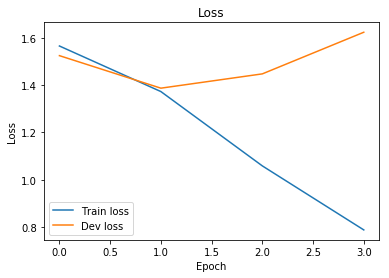

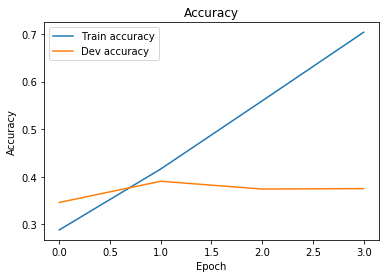

In [26]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

# training parameters
bs = 64
n_epochs = 5
cb = [
    EarlyStopping(monitor='val_acc', patience=2, verbose=0),
    ModelCheckpoint(filepath='weights.hdf5', verbose=0, save_best_only=True)
]

# datasets
x_train = X_train_pad
x_dev = X_dev_pad

_, y_train = load_data(train_filepath)
_, y_dev = load_data(dev_filepath)
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)

# training
history = model.fit(x_train,
                    y_train,
                    batch_size=bs,
                    epochs=n_epochs,
                    validation_data=(x_dev, y_dev), 
                    callbacks=cb)

# plot loss
plt.figure()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Dev loss')

plt.legend(loc='best')
plt.show()

# plot accuracy
plt.figure()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Dev accuracy')

plt.legend(loc='best')
plt.show()

In [27]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model.load_weights('weights.hdf5')
np.savetxt('logreg_lstm_y_test_sst.txt', model.predict(X_test_pad).argmax(axis=1), fmt='%.d')

## 4.3 - innovate !

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 15s 2ms/step - loss: 1.5692 - acc: 0.2755 - val_loss: 1.5562 - val_acc: 0.3315
Epoch 2/5
8544/8544 [==============================] - 13s 1ms/step - loss: 1.4380 - acc: 0.3708 - val_loss: 1.3775 - val_acc: 0.3878
Epoch 3/5
8544/8544 [==============================] - 12s 1ms/step - loss: 1.1861 - acc: 0.4812 - val_loss: 1.3739 - val_acc: 0.3951
Epoch 4/5
8544/8544 [==============================] - 11s 1ms/step - loss: 0.9722 - acc: 0.5918 - val_loss: 1.4932 - val_acc: 0.3787
Epoch 5/5
8544/8544 [==============================] - 11s 1ms/step - loss: 0.7863 - acc: 0.6802 - val_loss: 1.6874 - val_acc: 0.3442


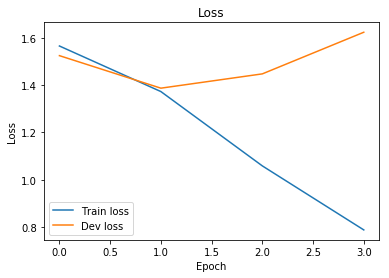

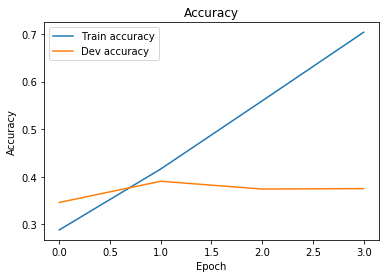

In [30]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
seed(1)

from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D

# training parameters
n_classes   = 5
bs          = 64
n_epochs    = 5
cb = [
    EarlyStopping(monitor='val_acc', patience=2, verbose=0),
    ModelCheckpoint(filepath='weights2.hdf5', verbose=0, save_best_only=True)
]

# embedding
embed_dim   = 100  # word embedding dimension
vocab_size  = 50000  # size of the vocabulary

# LSTM
nhid        = 100  # number of hidden units in the LSTM

# convolution
kernel_size = 5
filters     = 64
pool_size   = 4

# create the model
model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Dropout(0.5))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(nhid, dropout=.2, recurrent_dropout=.2))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

# optimization parameters
loss_classif     =  'categorical_crossentropy'
optimizer        =  'adam'
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

# training
history2 = model.fit(x_train,
                     y_train,
                     batch_size=bs,
                     epochs=n_epochs,
                     validation_data=(x_dev, y_dev),
                     callbacks=cb)

# plot loss
plt.figure()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Dev loss')

plt.legend(loc='best')
plt.show()

# plot accuracy
plt.figure()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Dev accuracy')

plt.legend(loc='best')
plt.show()

# predict
model.load_weights('weights2.hdf5')
np.savetxt('convnet_lstm_y_test_sst.txt', model.predict(X_test_pad).argmax(axis=1), fmt='%.d')